In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.gridspec as gridspec

pylab.rcParams['figure.figsize'] = 60, 20
pylab.rcParams["font.size"] = "36"
pylab.rcParams['lines.linewidth'] = 5

from FDemo_nb import *

import csv

from scipy import ndimage

from ipywidgets import widgets, interact, interactive, fixed, interact_manual, Layout, IntSlider
from IPython.display import display, FileLink, FileLinks, Image

import fileupload

import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



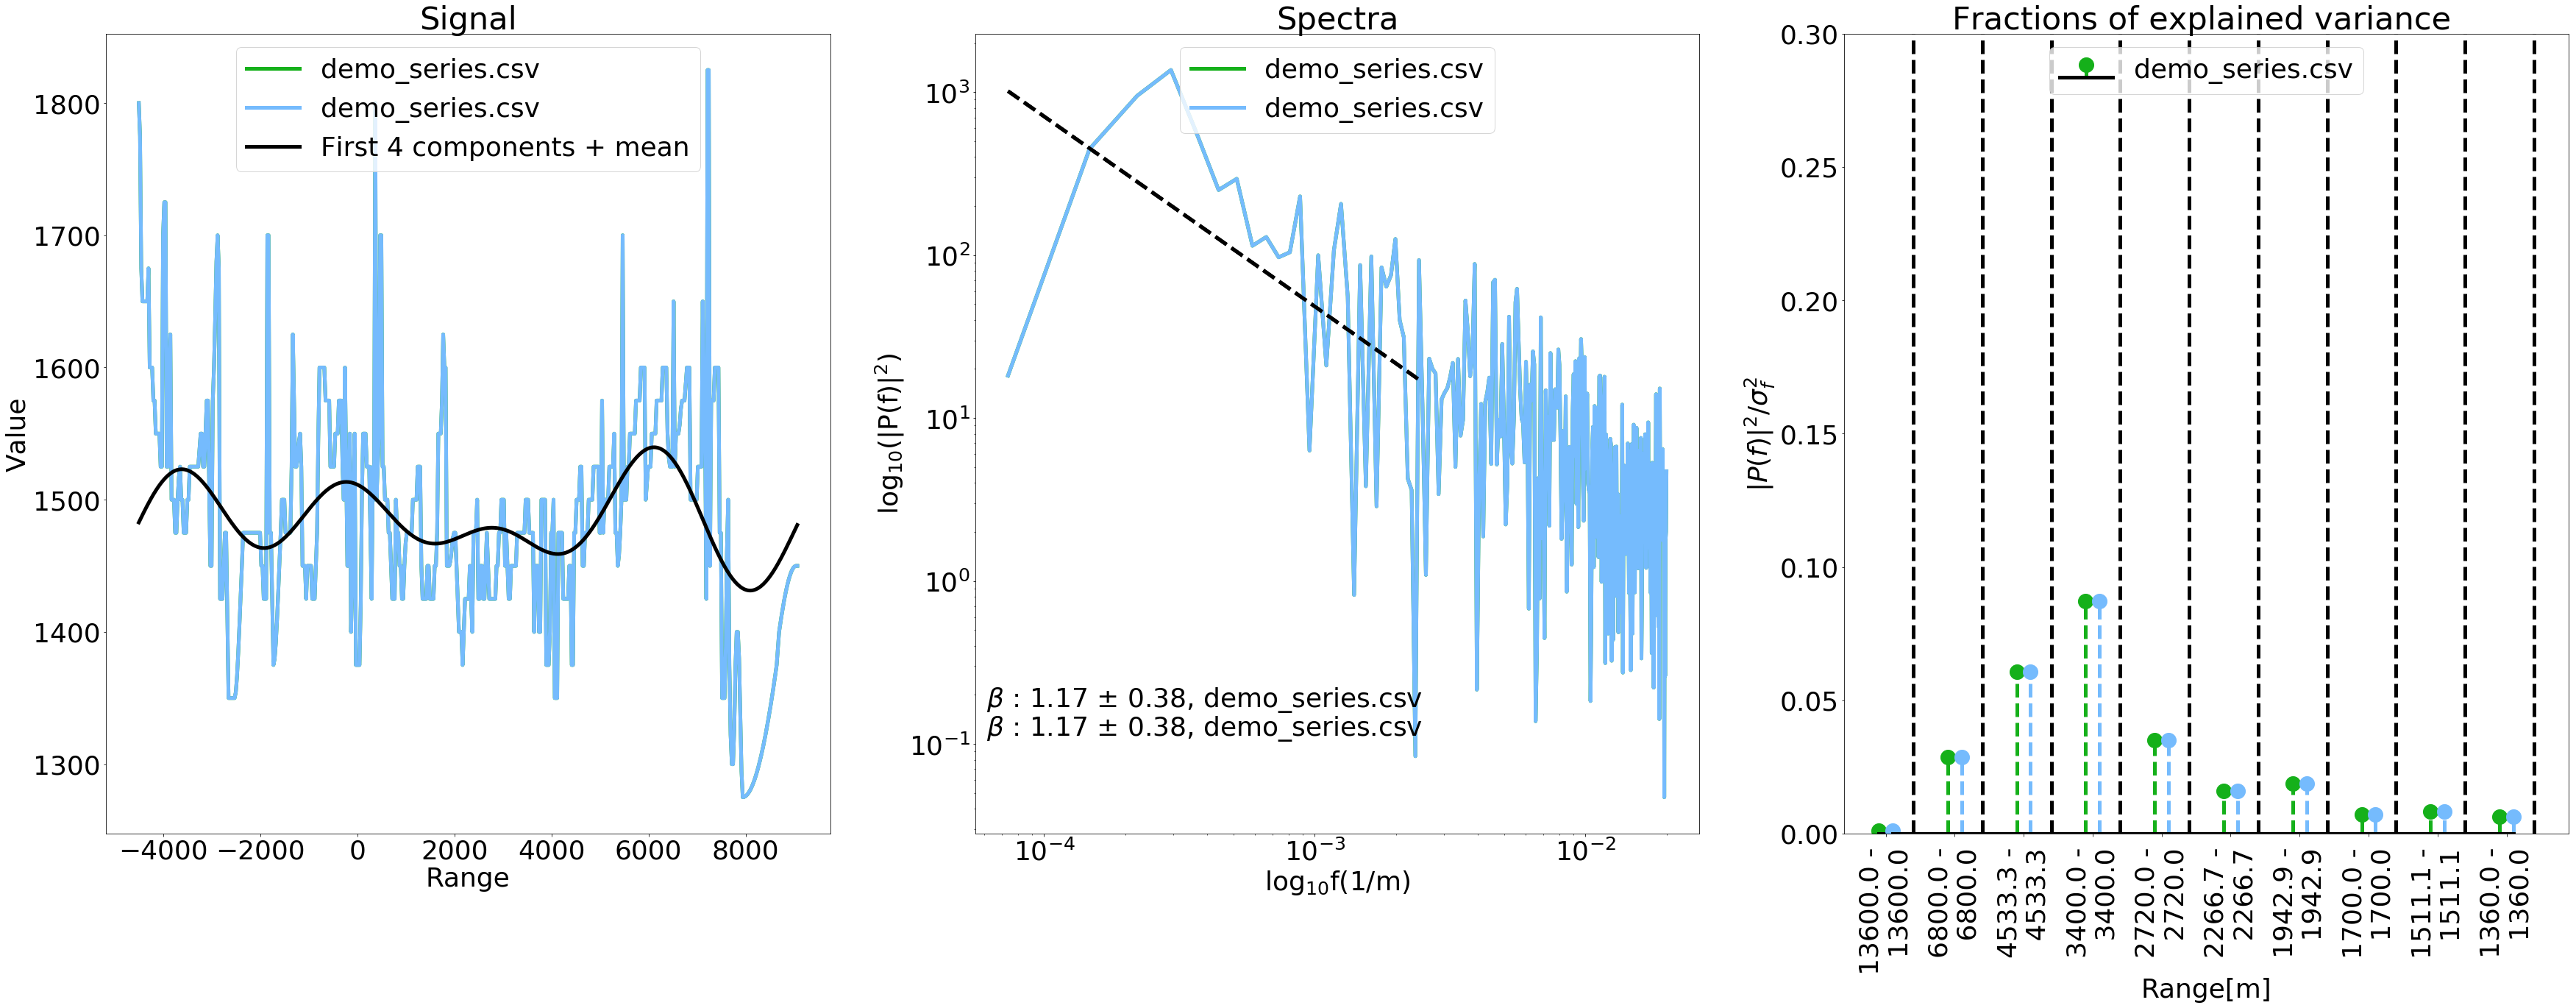

Download your image here: 


/home/fvanden/Documents/EPFL/Python/FourierNotebook/FourierTemp.png

In [3]:
def repairData(uploader_data, filename):
    if uploader_data == b'':
        xvals = []
        tops = []
        filename = 'demo_series.csv'
        
        with open(filename, 'r') as f:
            reader = csv.reader(f, delimiter = ',')
            header = next(reader)
            for row in reader:
                xvals.append(float(row[0]))
                tops.append(float(row[1]))
                
    else:
        filename = filename
        
        xvals = []
        tops = []


        spltdata = uploader_data.split(b'\r\n')[:-1]
        if len(spltdata) == 0:
            spltdata = uploader_data.split(b'\n')[:-1]

        for i in range(0, len(spltdata)):
            tmpline = []
            if i == 0:
                pass
            else:
                xvals.append(float(spltdata[i].decode("utf-8").split(',')[0]))
                tops.append(float(spltdata[i].decode("utf-8").split(',')[1]))
    
    return xvals, tops, filename

uploader = fileupload.FileUploadWidget()
uploader.filename
uploader2 = fileupload.FileUploadWidget()
uploader2.filename

downloader = widgets.Button(
    description='Download Figure',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Download Figure'
)


def _handle_upload(change):
    w = change['owner']
    with open(w.filename, 'wb') as f:
        f.write(w.data)
    print('Uploaded `{}` ({:.2f} kB)'.format(
        w.filename, len(w.data) / 2**10))

uploader.observe(_handle_upload, names='data')
uploader2.observe(_handle_upload, names='data')

display(uploader)
display(uploader2)


def load_sample_ml(loader = 1):
    
    if loader == 1:
        x, top, filename = repairData(uploader.data, uploader.filename)
    elif loader == 2:
        x, top, filename = repairData(uploader2.data, uploader2.filename)
        
    x1, s1, tds1, ys1, tdys1, lds1, xs1_slope = prepareData(top, x, lim = 15)
    
    return x1, s1, filename

def create_artificial_ml(num_samples, mean = 1, std = 1/50):

    incr = np.arange(1600, 1700, (1700-1600)/num_samples)
    s3 = np.random.normal(mean, std, size=num_samples) * incr 
        
    return s3    

def update(ftype = 'spatial',d=4, c=[0], Fs = 5, medfilter = False, medfilterval = 5, bell_taper = False):
      
    
    fig, (ax1, ax3, ax2) = plt.subplots(1,3)
    
    ax1.set_title('Signal')
    
    x1, s1, fname1 = load_sample_ml(loader = 1)
    x3, s3, fname2 = load_sample_ml(loader = 2)
    
    plotconfig = {}
    plotconfig['spatial'] = {'xlab':'Range', 'plot1lab':fname1, 'plot2lab':fname2, 'rescor1': 1, 'rescor2': None,
                             'units': 'm'}
    plotconfig['temporal'] = {'xlab':'Time', 'plot1lab':fname1, 'plot2lab':fname2, 'rescor1': 60,'rescor2': None,
                              'units' :'min'}
    
    
    if c[0] == 0:
        
        if medfilter is True and bell_taper is True:
            s3 = ndimage.median_filter(s3,medfilterval)
            s1 = ndimage.median_filter(s1,medfilterval)
            s3,lintrend,slope  = my_detrend_simple(s3, x3)
            s1,lintrend,slope  = my_detrend_simple(s1,x1)
            s3 = belltaper(s3)
            s1 = belltaper(s1)
        elif medfilter is True:
            s3 = ndimage.median_filter(s3,medfilterval)
            s1 = ndimage.median_filter(s1,medfilterval)
        elif bell_taper is True:
            s3,lintrend,slope  = my_detrend_simple(s3, x3)
            s1,lintrend,slope  = my_detrend_simple(s1, x1)
            s3 = belltaper(s3)
            s1 = belltaper(s1)
    else:
        
        if medfilter is True and bell_taper is True:
            s3 = ndimage.median_filter(s3,medfilterval)
            s1 = ndimage.median_filter(s1,medfilterval)
            s3,lintrend,slope  = my_detrend_simple(s3, x3)
            s1,lintrend,slope  = my_detrend_simple(s1, x1)
            s3 = belltaper(s3)
            s1 = belltaper(s1)
        elif medfilter is True:
            s3 = ndimage.median_filter(s3,medfilterval)
            s1 = ndimage.median_filter(s1,medfilterval)
        elif bell_taper is True:
            s3,lintrend,slope  = my_detrend_simple(s3, x3)
            s1,lintrend,slope  = my_detrend_simple(s1, x1)
            s3 = belltaper(s3)
            s1 = belltaper(s1)
        
        s3 = replaceSingleComp(s3, s1, d=c, Fs = Fs, m= True)
        
    
    ax1.plot(x1, s1, color = 'xkcd:green',label = fname1 )
    ax1.plot(x3, s3, color = 'xkcd:sky blue', label = fname2 )

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        mysignal1 = reduceDimFast(s1, d = d, Fs = Fs)
    
    l =  (('First %d components + mean')%(d))
    ax1.plot(x1, mysignal1, 'k', label = l)

    ax1.legend()
        
    ax1.set_xlabel(plotconfig[ftype]['xlab'])
    ax1.set_ylabel('Value')
    
    ax2 = createFreqPlot(ax2,s1, s3, Fs1 = Fs, Fs2 = Fs, config = plotconfig[ftype])
    
    ax3 = createSpectraPlot(ax3, s1, s3, Fs = Fs, config = plotconfig[ftype])
    
    
    fig.canvas.draw()
    fig.savefig('./FourierTemp.png')
    
def download_figure(b): 
    out = FileLink('./FourierTemp.png')
    print("Download your image here: ")
    display(out)

    
    
interact(update, ftype = widgets.ToggleButtons(options = ['temporal', 'spatial'], value = 'spatial'),
        d=widgets.IntSlider(min=1,max=11,step=1,value=4, description = '# comp', 
                                     slider_color='white', continuous_update=False),
        c=widgets.SelectMultiple(options=[0,1,2,3,4,5,6,7,8,9,10,11],value=[0], description = '# comp2'),
        Fs = widgets.IntText(value=25, description='Data Res:', disabled=False),
        medfilter = widgets.Checkbox(description = "median filter", value = False),
        medfilterval = widgets.IntText(value=5, description='Med filt:', disabled=False),
        bell_taper = widgets.Checkbox(description = "belltaper", value = False));


display(downloader)
downloader.on_click(download_figure)